In [1]:
from sklearn import model_selection
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester, list_transformer
from sklearn import linear_model as LM
import seaborn as sns
import pickle as pk
from matplotlib import pyplot as plt


# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv',
 'SampleMetaDataClean.csv',
 'SampleMetaDataManual.csv',
 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.shape

(4347, 38)

In [6]:
filter_indices = np.logical_and(SampleMeta["Study Accession"].isin(['PRJEB21528']).to_numpy(), SampleMeta["BMI"].to_numpy() != -99)
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape

(274, 38)

In [7]:
SampleMeta.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'study',
       'Study No. (From VG sheet (V-*) from SB sheet (S-*))', 'Title of Paper',
       'Author (year)', 'Journal', 'Study Accession',
       'Sample Accession or Sample ID', 'Sample title (ENA/SRA)',
       'Sample title (Paper)', 'Subject Id (If available)', 'Age (Years)',
       'BMI', 'Gender', 'GRoP', 'Phenotype', 'FBG', 'TRIG', 'LDLC', 'CHOL',
       'HDLC', 'Phys_Ex', 'Smoking', 'Residence', 'milk', 'meat', 'alcohol',
       'Diet1', 'Diet2', 'medication', 'Sequencing Platform',
       'Library layout (SINGLE/PAIRED)', 'Read count after Quality control',
       'Healthy', 'age_group', 'age_category'],
      dtype='object')

In [8]:
SampleMeta['meat'].value_counts()

-99    274
Name: meat, dtype: int64

In [9]:
np.any(SampleMeta['Age (Years)'] == -99)

False

In [10]:
SampleMeta['milk'].value_counts()

-99    274
Name: milk, dtype: int64

In [11]:
SampleMeta['Gender'].value_counts()

M    160
F    114
Name: Gender, dtype: int64

In [12]:
np.sum(SampleMeta['BMI'] == -99)

0

In [13]:
SampleMeta["Phenotype"].value_counts()

ACVD           144
Healthy         75
Overweight      40
Obesity          8
Underweight      7
Name: Phenotype, dtype: int64

In [14]:
MatrixData = MatrixData[ filter_indices ]
MatrixData.shape

(274, 903)

In [15]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


In [16]:
ClinicalContinuousMat = SampleMeta.loc[:, ['Age (Years)', 'BMI']].to_numpy().astype('float64')

In [17]:
ClinicalBinaryMat = (SampleMeta.loc[:, ['Gender']].to_numpy() == 'M').astype('float64')
ClinicalBinaryMat.shape

(274, 1)

In [18]:
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


In [19]:
X = [MatrixData, ClinicalContinuousMat, ClinicalBinaryMat]

In [20]:
y = SampleMeta['Phenotype'].to_numpy().astype('str') == 'ACVD'
y = y.astype('int64')

In [21]:
pd.value_counts(SampleMeta['Phenotype'])

ACVD           144
Healthy         75
Overweight      40
Obesity          8
Underweight      7
Name: Phenotype, dtype: int64

# Define and Train Model

In [22]:
# make pipeline
microbiome_pipeline = Pipeline([('scaler0', StandardScaler()), ('pca', PCA(n_components=100))])
clinical_continous_pipeline = StandardScaler()
clinical_binary_pipeline = FunctionTransformer()
pipeline_list = [microbiome_pipeline, clinical_continous_pipeline, clinical_binary_pipeline]
pipeline_list_transformer = list_transformer(pipeline_list)
pipeline_list_transformer.fit(X)
X_transform = pipeline_list_transformer.transform(X)

In [23]:
X_transform.shape

(274, 103)

In [24]:
pc_names = np.array(['PC' + str(i+1) for i in range(100)])
ClinDataNames = np.array(['Age (z)', 'BMI, (z)', 'Gender'])
X_transform_df = pd.DataFrame(X_transform, columns = np.concatenate([pc_names, ClinDataNames]))
X_transform_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC94,PC95,PC96,PC97,PC98,PC99,PC100,Age (z),"BMI, (z)",Gender
0,12.279385,-3.359436,0.094367,0.897768,-3.273225,-1.475070,0.977926,-1.704043,1.547316,-0.507823,...,-0.145464,-0.087689,0.428990,-0.583283,0.534917,-0.158664,-0.021711,42.827397,22.58,1.0
1,-1.099429,-0.419612,0.417405,1.459930,-0.175930,0.562761,-2.232190,-0.764115,1.384567,-0.083253,...,0.162604,2.942635,1.702117,2.568998,0.929916,1.698672,-0.744007,76.027397,24.03,0.0
2,-1.477555,0.081284,0.253886,0.072290,-0.413558,-0.786071,-0.416598,0.256669,-0.308917,-0.353521,...,-0.093796,-0.203819,-1.060155,-0.675182,-0.123485,-0.649286,-0.087144,73.000000,27.55,1.0
3,1.462924,2.070713,1.714120,-2.292561,1.200677,1.247274,-3.040912,0.955362,5.149746,1.142298,...,0.706237,-0.351116,-0.597005,-0.315500,-0.616302,0.602262,-0.074719,45.397260,23.62,1.0
4,4.328104,0.732943,1.293565,-1.891403,-3.542643,0.883771,6.187343,0.809476,2.504442,-0.368114,...,-0.182818,-0.377154,2.426089,0.218502,-3.111762,-0.288052,0.474292,64.589041,24.44,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,-2.266230,0.090327,-2.125849,-0.572833,1.512752,0.626963,-1.191608,0.016894,0.030992,0.266017,...,0.244188,1.291294,-1.004100,2.039166,-0.385071,-0.610676,0.316712,50.000000,18.31,0.0
270,-1.130871,0.142764,-0.781807,-0.380622,0.427577,0.975677,-2.252675,-0.280390,1.060447,0.139314,...,2.338937,-1.645575,0.402917,1.751347,2.093961,0.706413,0.606551,74.000000,16.61,0.0
271,-2.125734,0.273571,-1.429240,-0.527760,1.044861,0.050172,-1.142292,0.252315,-0.133182,0.085551,...,-0.653253,-1.048082,-1.188734,-2.527719,-1.531300,1.312439,0.865430,67.000000,16.82,0.0
272,-1.513136,0.801200,0.467076,1.448845,0.744847,-1.869821,-0.854482,-1.175395,-0.885762,-0.303366,...,0.937561,1.511540,-1.141062,4.993145,0.493129,3.620921,3.814981,61.000000,17.90,0.0


In [25]:
cor_df = X_transform_df.corr(method='pearson', min_periods=1)
cor_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC94,PC95,PC96,PC97,PC98,PC99,PC100,Age (z),"BMI, (z)",Gender
PC1,1.000000e+00,9.145803e-17,-3.390771e-16,1.164312e-16,2.469662e-16,-4.600827e-16,2.648888e-16,1.096848e-16,-6.340944e-18,-1.328856e-16,...,-3.113264e-17,8.484644e-17,2.964497e-17,1.422967e-17,4.397258e-17,4.098678e-17,8.594100e-17,-0.053079,-0.014925,0.144011
PC2,9.145803e-17,1.000000e+00,1.116415e-16,8.026593e-16,-2.300926e-16,-1.641573e-16,6.259950e-17,2.280602e-16,9.988853e-17,8.081115e-17,...,8.179458e-18,4.346431e-17,-5.152889e-17,2.043453e-17,-2.768536e-17,-3.816949e-17,1.038804e-17,0.087200,-0.017748,0.013749
PC3,-3.390771e-16,1.116415e-16,1.000000e+00,-2.753417e-16,-2.821045e-16,1.031817e-15,-1.104382e-16,-4.155876e-16,8.866568e-17,-4.611773e-17,...,5.642480e-18,-3.024308e-18,1.420856e-16,-8.567958e-17,9.858595e-17,4.923496e-17,-7.117488e-17,0.131117,-0.026087,0.119162
PC4,1.164312e-16,8.026593e-16,-2.753417e-16,1.000000e+00,4.690145e-16,1.922496e-16,8.038378e-17,-8.497661e-16,-5.456016e-16,-3.605500e-16,...,-6.121805e-17,-5.200886e-17,1.416187e-16,-1.021008e-18,-2.737489e-17,2.155007e-17,2.664521e-18,0.091641,-0.089648,0.022682
PC5,2.469662e-16,-2.300926e-16,-2.821045e-16,4.690145e-16,1.000000e+00,1.737882e-15,1.288109e-15,-2.493474e-16,-5.345381e-16,-7.594177e-18,...,-8.528781e-17,-1.239977e-16,3.036244e-16,6.807231e-17,-9.440668e-17,-1.954458e-16,-5.201485e-17,0.039424,-0.041682,-0.030910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC99,4.098678e-17,-3.816949e-17,4.923496e-17,2.155007e-17,-1.954458e-16,-9.046811e-17,-1.930756e-16,-1.701937e-16,4.557557e-16,-8.856186e-18,...,2.051712e-16,-6.850282e-16,-1.201989e-15,4.330579e-16,-8.291703e-16,1.000000e+00,3.329267e-16,-0.027232,0.014837,-0.051121
PC100,8.594100e-17,1.038804e-17,-7.117488e-17,2.664521e-18,-5.201485e-17,1.543367e-16,-2.390160e-16,8.454575e-17,-7.826732e-17,-1.755396e-16,...,4.874850e-16,8.069847e-16,-7.755210e-16,1.382843e-16,-4.521200e-16,3.329267e-16,1.000000e+00,0.095455,0.027647,-0.054806
Age (z),-5.307887e-02,8.719990e-02,1.311173e-01,9.164116e-02,3.942424e-02,-1.905075e-01,-7.138871e-02,1.025304e-01,1.001344e-01,-6.719642e-02,...,1.016108e-01,7.678610e-02,3.996171e-04,2.038126e-02,1.380902e-02,-2.723188e-02,9.545547e-02,1.000000,-0.121559,0.099722
"BMI, (z)",-1.492550e-02,-1.774751e-02,-2.608709e-02,-8.964808e-02,-4.168229e-02,1.303335e-01,2.563042e-02,2.949153e-02,6.092852e-02,-2.033978e-02,...,-7.215418e-02,4.958158e-02,3.996011e-03,-1.344051e-02,-4.446631e-02,1.483691e-02,2.764741e-02,-0.121559,1.000000,0.072149


In [26]:
X_transform_df['Gender'].value_counts()

1.0    160
0.0    114
Name: Gender, dtype: int64

In [27]:
SampleMeta['Gender']

0       M
1       F
2       M
3       M
4       F
       ..
4302    F
4303    F
4304    F
4305    F
4306    F
Name: Gender, Length: 274, dtype: object

<AxesSubplot:>

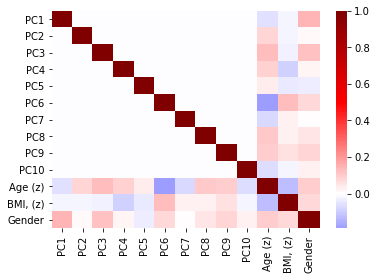

In [42]:
vars_plot = np.concatenate((pc_names[0:10], ClinDataNames))
cor_df_subs = cor_df.loc[vars_plot, vars_plot]
sns.heatmap(cor_df_subs, cmap=plt.cm.seismic, center=0)

In [33]:
cor_mat_subs = cor_df_subs.to_numpy().astype('float64')

In [34]:
np.triu_indices(3, k=1)

(array([0, 0, 1]), array([1, 2, 2]))

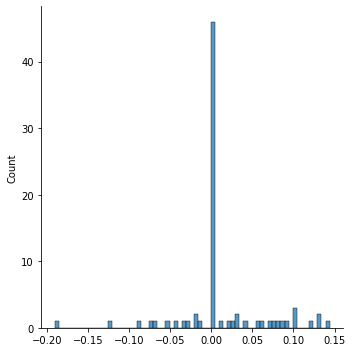

In [37]:
sns.displot(cor_mat_subs[np.triu_indices(13, 1)])